In [5]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../bin/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


Data requirements: PBR matrix, oncogene/tsgene files, (immune infiltration, tumor type, ancestory) <- maybe can be combined?

In [6]:
PATH_TO_DATA = '/cellar/users/ramarty/Data/hla/git_data/'

In [9]:
patient_affinities = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_affinities.cancer.TCGA.conservative.mut.ClassII.csv', index_col=0).dropna()
patient_mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_mutations.cancer.TCGA.conservative.mut.csv', index_col=0).dropna()
all_mutations = list(patient_affinities.columns)

Make native dataframe

In [24]:
patient_affinities_native = pd.concat([pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/tsgenes.all.wt.csv', index_col=0),
          pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/oncogenes.all.wt.csv', index_col=0),
          pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/patient_matrices/indels.all.wt.csv', index_col=0)]).transpose()
patient_affinities_native['MLLT4_S1510N'] = patient_affinities_native['AFDN_S1510N']

In [25]:
patient_affinities_native = patient_affinities_native.ix[patient_affinities.index, 
                                                         patient_affinities.columns].dropna()

In [26]:
print patient_affinities.shape
print patient_affinities_native.shape

(5942, 1018)
(5826, 1018)


In [27]:
oncogenes = [x.strip() for x in open(PATH_TO_DATA + 'data/onco_genes.txt').readlines()]
tsgenes = [x.strip() for x in open(PATH_TO_DATA + 'data/tumor_suppressor_genes.txt').readlines()]
onco_muts = [x for x in all_mutations if x.split('_')[0] in oncogenes]
ts_muts = [x for x in all_mutations if x.split('_')[0] in tsgenes]
missense_muts = [x for x in all_mutations if len(x.split('_')) == 2]
indel_muts = [x for x in all_mutations if len(x.split('_')) == 3]

Restricting the patients for visibility purposes

In [28]:
clinical = pd.read_csv(PATH_TO_DATA + 'data/clinical/ancestory.csv', index_col=0)

In [29]:
clinical.head()

,race
TCGA-02-0001,WHITE
TCGA-02-0003,WHITE
TCGA-02-0004,WHITE
TCGA-02-0006,WHITE
TCGA-02-0007,WHITE


In [30]:
patient_affinities.shape

(5942, 1018)

In [31]:
clinical.ix[[x for x in clinical.index if x in list(patient_affinities_native.index)]].race.value_counts()

WHITE                                        4337
ASIAN                                         386
BLACK OR AFRICAN AMERICAN                     351
AMERICAN INDIAN OR ALASKA NATIVE                7
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER       1
Name: race, dtype: int64

In [33]:
sampling_number = 350
asian = pd.Series([x for x in list(clinical[clinical.race.isin(['ASIAN'])].index) if x in list(patient_affinities_native.index)]).sample(sampling_number)
black = pd.Series([x for x in list(clinical[clinical.race.isin(['BLACK OR AFRICAN AMERICAN'])].index) if x in list(patient_affinities_native.index)]).sample(sampling_number)
white = pd.Series([x for x in list(clinical[clinical.race.isin(['WHITE'])].index) if x in list(patient_affinities_native.index)]).sample(sampling_number)
print len(asian), len(black), len(white)

350 350 350


In [34]:
# restrict to patients in mutated data frame
patients = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/generated_data/overview/clustered_indices.without.indels.txt').readlines()]

In [36]:
asian = pd.Series([x for x in list(clinical[clinical.race.isin(['ASIAN'])].index) if x in patients])
black = pd.Series([x for x in list(clinical[clinical.race.isin(['BLACK OR AFRICAN AMERICAN'])].index) if x in patients])
white = pd.Series([x for x in list(clinical[clinical.race.isin(['WHITE'])].index) if x in patients])
print len(asian), len(black), len(white)

350 350 350


In [37]:
restricted_patients = list(asian) + list(black) + list(white)
patient_affinities_small = patient_affinities_native.ix[restricted_patients, :]
patient_mutations_small = patient_mutations.ix[restricted_patients, :]

Mutation variables

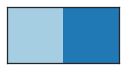

In [38]:
# add mutation type
mutation_df = pd.DataFrame({'Classification': ['Missense' for x in missense_muts if x in patient_affinities_native.columns],
                                 'Mutation': [x for x in missense_muts if x in patient_affinities_native.columns]})
cmap = sns.color_palette("Paired", 2)
def map_colors(x):
    if x == 'Missense':
        return cmap[0]
    elif x == 'Indel':
        return cmap[1]
mutation_df['Color'] = mutation_df['Classification'].apply(map_colors)
sns.palplot(sns.color_palette("Paired", 2))

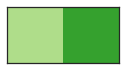

In [39]:
# add oncogene or tumor suppressor
gene_df = pd.DataFrame({'Classification': ['Onco' for x in onco_muts if x in patient_affinities_native.columns] 
                        + ['TS' for x in ts_muts if x in patient_affinities_native.columns],
                                 'Mutation': [x for x in onco_muts if x in patient_affinities_native.columns] 
                        + [x for x in ts_muts if x in patient_affinities_native.columns]})
cmap = sns.color_palette("Paired", 4)
def map_colors(x):
    if x == 'Onco':
        return cmap[2]
    elif x == 'TS':
        return cmap[3]
gene_df['Color'] = gene_df['Classification'].apply(map_colors)
sns.palplot(sns.color_palette("Paired", 4)[2:])

Patient variables

['LIHC', 'STAD', 'LUAD', 'KIRP', 'THCA', 'HNSC', 'COAD']


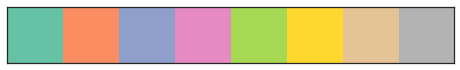

In [40]:
# add patient tissue - top 7 colors and then an 'other' color
patient_df = pd.read_csv(PATH_TO_DATA + 'data/patient_tissues.csv', index_col=0)
patient_df = patient_df.ix[restricted_patients]
large_tissues = list(patient_df.Tissue.value_counts().index[:7])
cmap = sns.color_palette("Set2", 10)
def map_colors(x):
    if x == large_tissues[0]:
        return cmap[0]
    elif x == large_tissues[1]:
        return cmap[1]
    elif x == large_tissues[2]:
        return cmap[2]
    elif x == large_tissues[3]:
        return cmap[3]
    elif x == large_tissues[4]:
        return cmap[4]
    elif x == large_tissues[5]:
        return cmap[5]
    elif x == large_tissues[6]:
        return cmap[6]
    else:
        # maybe change 'other' to white?
        return (1, 1, 1)
patient_df['Color'] = patient_df['Tissue'].apply(map_colors)
print large_tissues
sns.palplot(sns.color_palette("Set2", 8))

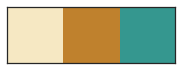

In [41]:
# add ethnicity to patient_df
clinical = pd.read_csv(PATH_TO_DATA + 'data/clinical/ancestory.csv', index_col=0)
patient_df = pd.merge(patient_df, clinical[['race']], left_index=True, right_index=True, how='left')
patient_df['race'] = list(patient_df['race'].fillna('OTHER'))
cmap = sns.color_palette("BrBG", 4)
def map_colors(x):
    if x == 'WHITE':
        return cmap[1]
    elif x == 'BLACK OR AFRICAN AMERICAN':
        return cmap[0]
    elif x == 'ASIAN':
        return cmap[3]
    else:
        return cmap[2]
patient_df['Ethnicity_Color'] = patient_df['race'].apply(map_colors)
sns.palplot([sns.color_palette("BrBG", 4)[1],sns.color_palette("BrBG", 4)[0],sns.color_palette("BrBG", 4)[3]])

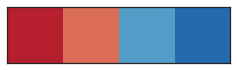

In [42]:
# add immune infiltration
hot_patients = [x.strip() for x in open(PATH_TO_DATA + 'data/clinical/immune_infiltration/hot_patients.txt').readlines() if x.strip() in restricted_patients]
cold_patients = [x.strip() for x in open(PATH_TO_DATA + 'data/clinical/immune_infiltration/cold_patients.txt').readlines() if x.strip() in restricted_patients]
warm_patients = [x.strip() for x in open(PATH_TO_DATA + 'data/clinical/immune_infiltration/warm_patients.txt').readlines() if x.strip() in restricted_patients]
cool_patients = [x.strip() for x in open(PATH_TO_DATA + 'data/clinical/immune_infiltration/cool_patients.txt').readlines() if x.strip() in restricted_patients]
immune_infil = []
for patient in list(patient_df.index):
    if patient in hot_patients:
        immune_infil.append('hot')
    elif patient in cold_patients:
        immune_infil.append('cold')
    elif patient in cool_patients:
        immune_infil.append('cool')
    elif patient in warm_patients:
        immune_infil.append('warm')
    else:
        immune_infil.append('neither')
patient_df['Immune_infil'] = immune_infil
cmap = sns.color_palette("RdBu", 8)
def map_colors(x):
    if x == 'hot':
        return cmap[0]
    elif x == 'warm':
        return cmap[1]
    elif x == 'neither':
        return (1,1,1)
    elif x == 'cool':
        return cmap[6]
    elif x == 'cold':
        return cmap[7]
patient_df['Immune_Color'] = patient_df['Immune_infil'].apply(map_colors)
sns.palplot(sns.color_palette("RdBu", 8)[:2] + sns.color_palette("RdBu", 8)[-2:])

Plot all together

In [43]:
patients = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/generated_data/overview/clustered_indices.without.indels.txt').readlines()]
mutations = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/generated_data/overview/clustered_columns.without.indels.txt').readlines()]

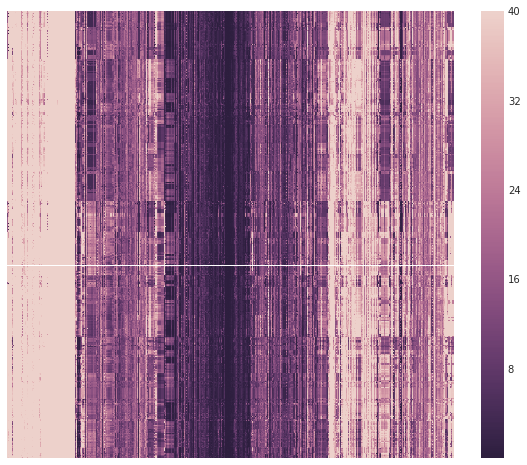

In [56]:
plt.figure(figsize = (10,8))
sns.heatmap(patient_affinities_small.ix[patients, mutations], 
               xticklabels=False, yticklabels=False,
               #row_colors=[list(patient_df.Ethnicity_Color), list(patient_df.Immune_Color), list(patient_df.Color)], 
               #col_colors=[list(mutation_df.Color), list(gene_df.Color)],
                vmax=40, cmap=sns.cubehelix_palette(reverse=True, as_cmap=True))
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/all/clustermap.PHBR.native.aligned_with_mut.pdf')

Statistics

In [44]:
patient_affinities.shape

(5942, 1018)

In [45]:
patient_affinities_native.shape

(5826, 1018)

In [59]:
median_comparision = pd.merge(pd.DataFrame(patient_affinities.median()), 
                   pd.DataFrame(patient_affinities_native.median()), left_index=True, right_index=True)
median_comparision.columns = ['Mutated', 'Native Germline']

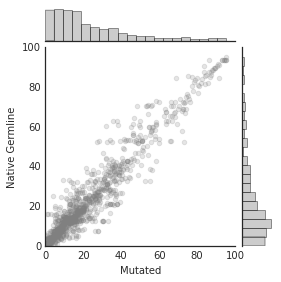

In [61]:
sns.jointplot(median_comparision.Mutated, median_comparision['Native Germline'], stat_func=None,
              xlim=(0, 100), ylim=(0, 100), alpha=0.2, color='grey', size=4)
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/all/clustermap.summary.pdf')

In [63]:
sp.pearsonr(median_comparision.Mutated, median_comparision['Native Germline'])

(0.95658920427832039, 0.0)